## Set-up

In [2]:
# load in libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import normalize
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read in data
foundlinks = pd.read_excel("foundlinks.modeling.xlsx")
foundlinks.head

<bound method NDFrame.head of                                                    url  \
0    http://bonddad.blogspot.com/2021/12/manufactur...   
1    http://bonddad.blogspot.com/2023/09/initial-jo...   
2    http://bostongis.org/?content_name=umn_datasou...   
3    http://bostongis.org/?content_name=umn_datasou...   
4    http://colonialsense.com/society-lifestyle/cen...   
..                                                 ...   
767   https://www.medfieldpubliclibrary.org/databases/   
768  https://www.nature.com/articles/s41893-020-006...   
769  https://www.plannedparenthoodaction.org/florid...   
770  https://www.socialexplorer.com/data/acs2006/me...   
771        https://yelmwa.gov/news_detail_t10_r448.php   

                                           Found Links  \
0                      http://www.census.gov/econ/www/   
1                      http://www.census.gov/econ/www/   
2       http://www.census.gov/geo/www/tiger/index.html   
3     http://www.census.gov/geo/www/cob/b

In [4]:
#Saving Found Links into a list for later analysis
urls = foundlinks['Found Links'].tolist()

In [108]:
#Checking for any missing values
anyna = foundlinks.isnull().values.any()
anyna

False

In [109]:
#getting rid of special characters and lower caseing content
pattern = r'[^a-zA-Z0-9\s]'
foundlinks['content'] = foundlinks['content'].str.replace(pattern,'',regex=True)
# Remove new line characters
foundlinks['content'] = foundlinks['content'].str.replace(r'\n', '', regex=True)
foundlinks = foundlinks.applymap(lambda x: x.lower() if isinstance(x, str) else x)

C:\Users\Ksell\AppData\Local\Temp\ipykernel_45544\4161804740.py:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [110]:
#Sites had multiple found links, combining them to reduce duplicate URls and content
unique_links_per_url = foundlinks.groupby('url')['Found Links'].unique().reset_index()
unique_links_per_url

,url,Found Links
0,http://bonddad.blogspot.com/2021/12/manufactur...,[http://www.census.gov/econ/www/]
1,http://bonddad.blogspot.com/2023/09/initial-jo...,[http://www.census.gov/econ/www/]
2,http://bostongis.org/?content_name=umn_datasou...,[http://www.census.gov/geo/www/tiger/index.htm...
3,http://colonialsense.com/society-lifestyle/cen...,[mailto:?subject=colonial sense: society-lifes...
4,http://fileformats.archiveteam.org/index.php?t...,[https://www.census.gov/programs-surveys/cps.h...
...,...,...
324,https://www.withdra.com/p/mind-the-gap-explori...,[https://www.census.gov/library/publications/2...
325,https://www.wxpr.org/2022-07-28/these-hurrican...,[https://data.census.gov/]
326,https://www.wyomingpublicmedia.org/news/2021-0...,[https://www.census.gov/data/experimental-data...
327,https://yelmwa.gov/i_want_to/contact/send_a_no...,[https://2020census.gov/en]


In [111]:
#key words for finding if site is repackaged or cited

keywords = ["tables","table","data","quickfacts"]

pattern = '|'.join(keywords)  # 'census|stats|data'

# Function to check if any link in the list contains a keyword
def contains_keyword(links, pattern):
    # Return True if any link contains a keyword, otherwise False
    return any(pd.notna(link) and pd.Series(link).str.contains(pattern, case=False, regex=True).any() 
               for link in links)

# Apply the function to create a new column 'contains_keywords'
unique_links_per_url['Source'] = unique_links_per_url['Found Links'].apply(lambda x: contains_keyword(x, pattern))
unique_links_per_url['Source'] = unique_links_per_url['Source'].replace({True: 'repackaged', False: 'cited'})

unique_links_per_url

,url,Found Links,Source
0,http://bonddad.blogspot.com/2021/12/manufactur...,[http://www.census.gov/econ/www/],cited
1,http://bonddad.blogspot.com/2023/09/initial-jo...,[http://www.census.gov/econ/www/],cited
2,http://bostongis.org/?content_name=umn_datasou...,[http://www.census.gov/geo/www/tiger/index.htm...,cited
3,http://colonialsense.com/society-lifestyle/cen...,[mailto:?subject=colonial sense: society-lifes...,cited
4,http://fileformats.archiveteam.org/index.php?t...,[https://www.census.gov/programs-surveys/cps.h...,cited
...,...,...,...
324,https://www.withdra.com/p/mind-the-gap-explori...,[https://www.census.gov/library/publications/2...,cited
325,https://www.wxpr.org/2022-07-28/these-hurrican...,[https://data.census.gov/],repackaged
326,https://www.wyomingpublicmedia.org/news/2021-0...,[https://www.census.gov/data/experimental-data...,repackaged
327,https://yelmwa.gov/i_want_to/contact/send_a_no...,[https://2020census.gov/en],cited


In [112]:
#combining 
combined_content = foundlinks.groupby('url')['content'].apply(' '.join).reset_index()
combined_content

,url,content
0,http://bonddad.blogspot.com/2021/12/manufactur...,the bonddad blog manufacturing still red hot c...
1,http://bonddad.blogspot.com/2023/09/initial-jo...,the bonddad blog initial jobless claims remain...
2,http://bostongis.org/?content_name=umn_datasou...,ogr odbcboston geographic information systemsh...
3,http://colonialsense.com/society-lifestyle/cen...,colonial sense societylifestyle census governa...
4,http://fileformats.archiveteam.org/index.php?t...,cps project just solve the file format proble...
...,...,...
324,https://www.withdra.com/p/mind-the-gap-explori...,vibecession exploring the growing divide betwe...
325,https://www.wxpr.org/2022-07-28/these-hurrican...,these hurricane flood maps reveal the climate ...
326,https://www.wyomingpublicmedia.org/news/2021-0...,single mothers bore brunt of coronavirus anxie...
327,https://yelmwa.gov/i_want_to/contact/send_a_no...,welcome to yelm washingtonskip to contentsearc...


In [113]:
final_data = pd.merge(unique_links_per_url, combined_content, on='url')
final_data

,url,Found Links,Source,content
0,http://bonddad.blogspot.com/2021/12/manufactur...,[http://www.census.gov/econ/www/],cited,the bonddad blog manufacturing still red hot c...
1,http://bonddad.blogspot.com/2023/09/initial-jo...,[http://www.census.gov/econ/www/],cited,the bonddad blog initial jobless claims remain...
2,http://bostongis.org/?content_name=umn_datasou...,[http://www.census.gov/geo/www/tiger/index.htm...,cited,ogr odbcboston geographic information systemsh...
3,http://colonialsense.com/society-lifestyle/cen...,[mailto:?subject=colonial sense: society-lifes...,cited,colonial sense societylifestyle census governa...
4,http://fileformats.archiveteam.org/index.php?t...,[https://www.census.gov/programs-surveys/cps.h...,cited,cps project just solve the file format proble...
...,...,...,...,...
324,https://www.withdra.com/p/mind-the-gap-explori...,[https://www.census.gov/library/publications/2...,cited,vibecession exploring the growing divide betwe...
325,https://www.wxpr.org/2022-07-28/these-hurrican...,[https://data.census.gov/],repackaged,these hurricane flood maps reveal the climate ...
326,https://www.wyomingpublicmedia.org/news/2021-0...,[https://www.census.gov/data/experimental-data...,repackaged,single mothers bore brunt of coronavirus anxie...
327,https://yelmwa.gov/i_want_to/contact/send_a_no...,[https://2020census.gov/en],cited,welcome to yelm washingtonskip to contentsearc...


## LDA Modeling

In [114]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words
stop_words = stopwords.words('english')
stop_words.extend(["data", "census", "bureau"])

# Preprocessing function to lemmatize text
def preprocess(text):
    tokens = text.split()  # tokenization
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]  
    return ' '.join(lemmatized)  # Return the lemmatized text

# Apply the preprocessing function to the content
final_data['content'] = final_data['content'].apply(preprocess)

# Vectorize the content with CountVectorizer
vec = CountVectorizer(stop_words=stop_words, max_df=0.9, min_df=0.1, token_pattern=r'\b[a-zA-Z]{3,}\b')
X = vec.fit_transform(final_data['content'])

# Map terms to their ids for gensim compatibility
terms = vec.get_feature_names_out()

# Prepare the texts as tokenized lists (for coherence calculation)
tokenized_texts = [doc.split() for doc in final_data['content']]

# Create dictionary for coherence model
dictionary = Dictionary(tokenized_texts)

# Range of topic numbers to test
topics_range = range(3, 25)

In [115]:
# Define a function to calculate coherence and exclusivity
def evaluate_topic_model(X, tokenized_texts, terms, num_topics, dictionary):
    # Initialize LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=225)
    lda.fit(X)

    # Calculate Coherence
    topics = []
    for topic in lda.components_:
        top_word_ids = topic.argsort()[-20:][::-1]  
        topic_words = [terms[i] for i in top_word_ids]
        topics.append(topic_words)

    coherence_model = CoherenceModel(
        topics=topics,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='u_mass'
    )
    coherence_score = coherence_model.get_coherence()

    # Calculate Exclusivity
    topic_word_distributions = normalize(lda.components_, norm='l1', axis=1)
    exclusivity_scores = []
    for i, topic in enumerate(topic_word_distributions):
        top_word_ids = topic.argsort()[-20:][::-1]
        top_words = [terms[idx] for idx in top_word_ids]

        # Calculate exclusivity as uniqueness of each word in the topic
        exclusivity = 0
        for word in top_words:
            word_count = sum(word in other_topic for other_topic in topics)
            exclusivity += 1 / word_count  # Higher exclusivity if the word is rare across topics
        exclusivity_scores.append(exclusivity / len(top_words))  # Average exclusivity for this topic

    # Average exclusivity across all topics
    average_exclusivity = np.mean(exclusivity_scores)

    return coherence_score, average_exclusivity


results = []

for num_topics in topics_range:
    coherence_score, exclusivity_score = evaluate_topic_model(X, tokenized_texts, terms, num_topics, dictionary)
    results.append({
        'num_topics': num_topics,
        'coherence': coherence_score,
        'exclusivity': exclusivity_score
    })

# Display results
for result in results:
    print(f"Topics: {result['num_topics']}, Coherence: {result['coherence']:.4f}, Exclusivity: {result['exclusivity']:.4f}")

Topics: 3, Coherence: -0.9821, Exclusivity: 0.8833
Topics: 4, Coherence: -0.9253, Exclusivity: 0.8375
Topics: 5, Coherence: -1.0263, Exclusivity: 0.8400
Topics: 6, Coherence: -1.0938, Exclusivity: 0.8250
Topics: 7, Coherence: -1.0877, Exclusivity: 0.8071
Topics: 8, Coherence: -1.0589, Exclusivity: 0.7812
Topics: 9, Coherence: -1.0478, Exclusivity: 0.7667
Topics: 10, Coherence: -1.0440, Exclusivity: 0.7600
Topics: 11, Coherence: -1.0060, Exclusivity: 0.7091
Topics: 12, Coherence: -1.0013, Exclusivity: 0.7083
Topics: 13, Coherence: -1.0344, Exclusivity: 0.7038
Topics: 14, Coherence: -1.0099, Exclusivity: 0.6857
Topics: 15, Coherence: -1.0222, Exclusivity: 0.6600
Topics: 16, Coherence: -1.0268, Exclusivity: 0.6500
Topics: 17, Coherence: -0.9997, Exclusivity: 0.6118
Topics: 18, Coherence: -1.0328, Exclusivity: 0.6250
Topics: 19, Coherence: -1.0263, Exclusivity: 0.5974
Topics: 20, Coherence: -1.0365, Exclusivity: 0.5850
Topics: 21, Coherence: -1.0132, Exclusivity: 0.5905
Topics: 22, Coheren

In [116]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Line plot for coherence over the range of topics
fig = px.line(
    df_results,
    x='num_topics',
    y=['coherence',],
    labels={'num_topics': 'Number of Topics', 'value': 'Score'},
    title='Coherence Scores for Different Number of Topics'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Number of Topics',
    yaxis_title='Score',
    legend_title_text='Metrics',
    showlegend=False
)

fig.show()

In [117]:
# Line plot for exclusivity over the range of topics
fig = px.line(
    df_results,
    x='num_topics',
    y=['exclusivity'],
    labels={'num_topics': 'Number of Topics', 'value': 'Score'},
    title='Exclusivity Scores for Different Number of Topics'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Number of Topics',
    yaxis_title='Score',
    legend_title_text='Metrics',
    showlegend=False
)

fig.show()

In [118]:
#Interactive graph of coherance and exclusivity
fig = px.scatter(
    df_results,
    x='coherence', 
    y='exclusivity',
    color='num_topics', 
    labels={
        'coherence': 'Coherence Score',
        'exclusivity': 'Exclusivity Score',
        'num_topics': 'Number of Topics'
    },
    title='Coherence vs. Exclusivity Scores for Different Number of Topics'
)

fig.update_traces(marker=dict(size=10), hovertemplate='Num Topics: %{marker.color}<br>Coherence: %{x}<br>Exclusivity: %{y}')

fig.update_layout(
    xaxis_title='Coherence Score',
    yaxis_title='Exclusivity Score',
    coloraxis_colorbar=dict(title='Number of Topics')
)

fig.show()

In [119]:
import plotly.io as pio
# Save the interactive graph to an HTML file to inbed in the power point presentation
pio.write_html(fig, file='Coherence_Exclusivity_interactive_graph.html', auto_open=True)

In [120]:
#LDA Topic Modeling
vec = CountVectorizer(stop_words=stop_words, max_df=0.80, min_df=0.20, token_pattern=r'\b[a-zA-Z]{3,}\b')
X = vec.fit_transform(final_data['content'])
lda = LatentDirichletAllocation(n_components=5, random_state=225)
doc_topics = lda.fit_transform(X)
print(lda.components_.shape[0]) #topics
print(lda.components_.shape[1]) #words

5
213


In [121]:
vocab = np.array(vec.get_feature_names_out())

n_words = 20
n_topics = 5 

def imp_words(topic, n_words):
    # Get indices of the top 'n_words' in descending order
    top_word_indices = np.argsort(topic)[-n_words:][::-1]
    return vocab[top_word_indices]
words_in_topic = [imp_words(topic, n_words) for topic in lda.components_]

# Display only the specified number of topics
for idx, words in enumerate(words_in_topic[:n_topics]):
    print(f"Topic #{idx}: {', '.join(words)}")

Topic #0: county, estimate, state, code, household, income, united, information, use, source, website, file, area, official, government, population, person, place, address, updated
Topic #1: survey, age, health, child, population, question, people, school, national, community, american, year, group, person, across, information, work, change, resource, level
Topic #2: state, home, new, health, care, city, information, community, public, service, business, research, access, resource, online, center, program, policy, department, including
Topic #3: house, good, statistic, housing, area, price, service, value, home, month, new, estimate, used, cost, made, state, percent, average, annual, united
Topic #4: year, may, people, one, market, also, time, new, like, march, would, family, business, rate, day, number, make, get, work, way


In [122]:
# Normalize topic-word distributions to get probabilities
topic_word_distributions = normalize(lda.components_, norm='l1', axis=1)

# Collect top words and their probabilities for each topic
top_words_with_probs = {}
for topic_idx, topic in enumerate(topic_word_distributions):
    top_word_ids = topic.argsort()[-n_words:][::-1]  # Get indices of top n words for this topic
    top_words_probs = [(vocab[i], topic[i]) for i in top_word_ids]  # Get word-probability pairs
    top_words_with_probs[f'Topic {topic_idx}'] = top_words_probs

# Display the results
for topic, words in top_words_with_probs.items():
    print(f"{topic}:")
    for word, prob in words:
        print(f"   {word}: {prob:.4f}")

Topic 0:
   county: 0.1071
   estimate: 0.0572
   state: 0.0379
   code: 0.0346
   household: 0.0259
   income: 0.0246
   united: 0.0240
   information: 0.0239
   use: 0.0211
   source: 0.0207
   website: 0.0200
   file: 0.0195
   area: 0.0191
   official: 0.0166
   government: 0.0162
   population: 0.0135
   person: 0.0134
   place: 0.0133
   address: 0.0133
   updated: 0.0131
Topic 1:
   survey: 0.1291
   age: 0.0959
   health: 0.0947
   child: 0.0704
   population: 0.0573
   question: 0.0375
   people: 0.0310
   school: 0.0300
   national: 0.0276
   community: 0.0273
   american: 0.0261
   year: 0.0254
   group: 0.0184
   person: 0.0117
   across: 0.0110
   information: 0.0108
   work: 0.0102
   change: 0.0098
   resource: 0.0095
   level: 0.0092
Topic 2:
   state: 0.0326
   home: 0.0257
   new: 0.0253
   health: 0.0231
   care: 0.0224
   city: 0.0215
   information: 0.0198
   community: 0.0194
   public: 0.0189
   service: 0.0175
   business: 0.0158
   research: 0.0157
   access: 0

In [123]:
plot_data = []
for topic, words in top_words_with_probs.items():
    for word, prob in words:
        plot_data.append({'Topic': topic, 'Word': word, 'Probability': prob})

df_plot = pd.DataFrame(plot_data)
df_plot_0 = df_plot[df_plot["Topic"]=="Topic 0"]
df_plot_1 = df_plot[df_plot["Topic"]=="Topic 1"]
df_plot_2 = df_plot[df_plot["Topic"]=="Topic 2"]
df_plot_3 = df_plot[df_plot["Topic"]=="Topic 3"]
df_plot_4 = df_plot[df_plot["Topic"]=="Topic 4"]

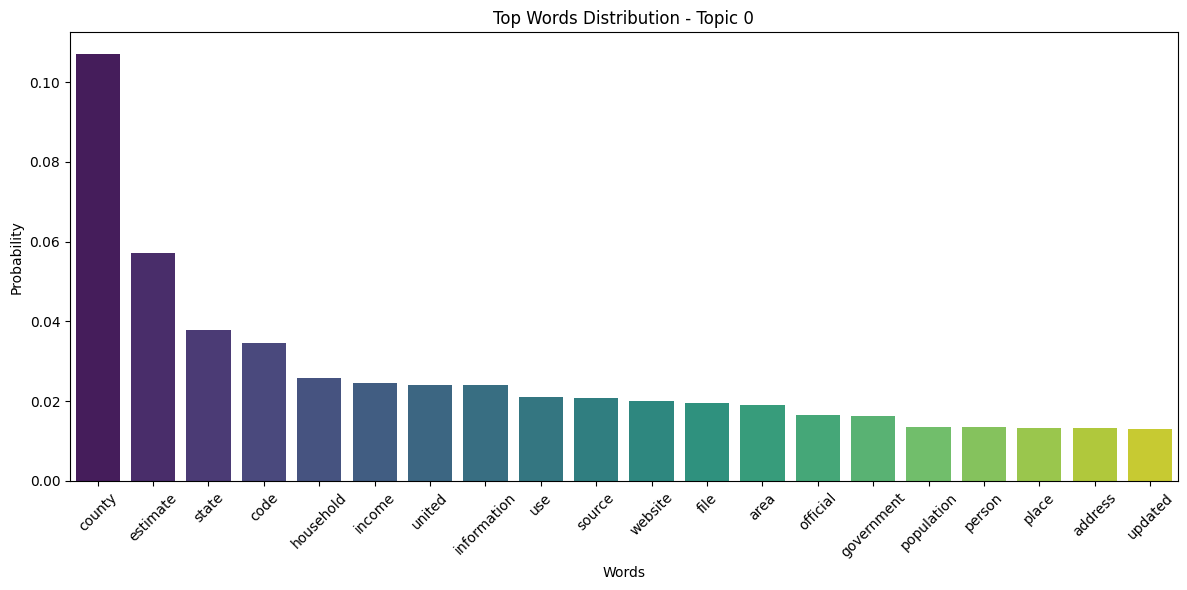

In [124]:
# Plotting the distributions
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot_0, x='Word', y='Probability', palette='viridis')

# Add title and labels
plt.title('Top Words Distribution - Topic 0')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

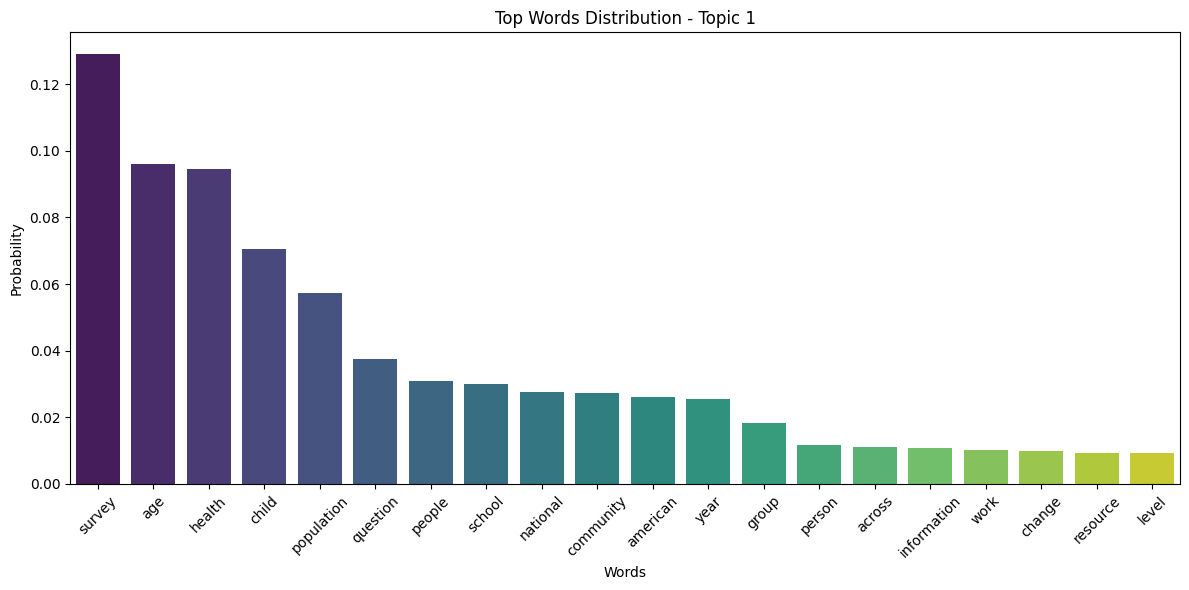

In [125]:
# Plotting the distributions
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot_1, x='Word', y='Probability', palette='viridis')

# Add title and labels
plt.title('Top Words Distribution - Topic 1')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

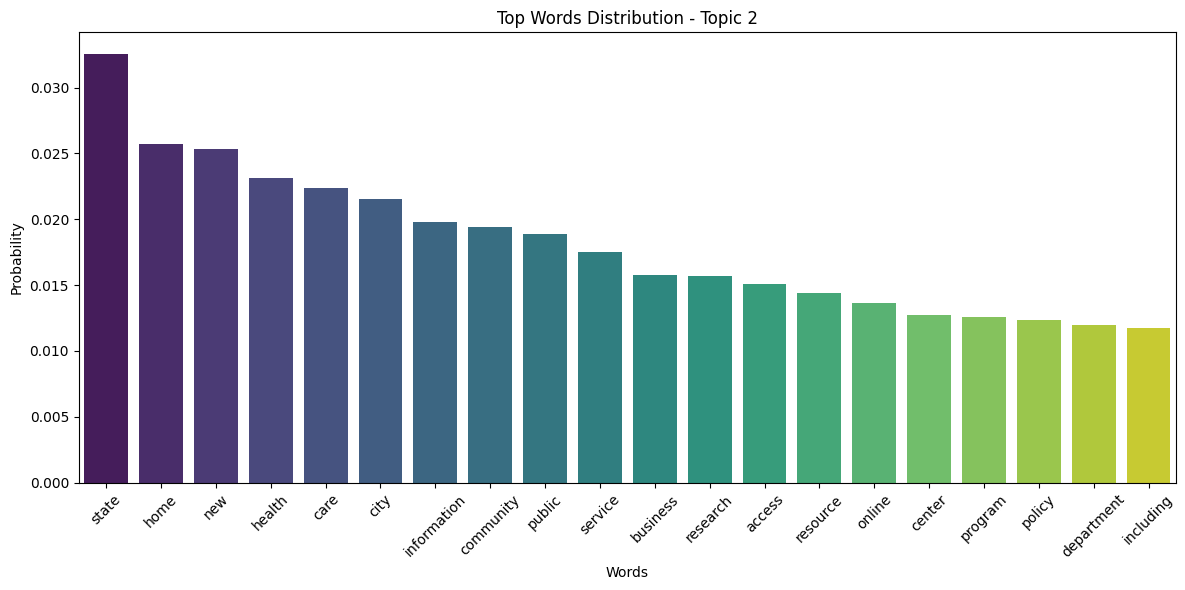

In [126]:
# Plotting the distributions
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot_2, x='Word', y='Probability', palette='viridis')

# Add title and labels
plt.title('Top Words Distribution - Topic 2')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

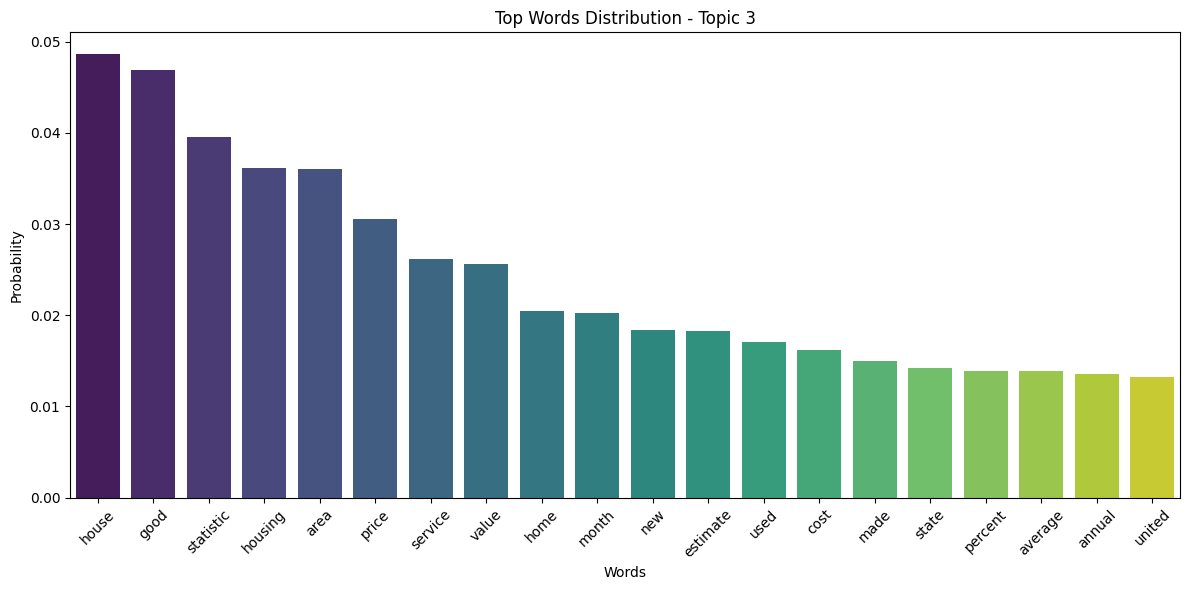

In [127]:
# Plotting the distributions
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot_3, x='Word', y='Probability', palette='viridis')

# Add title and labels
plt.title('Top Words Distribution - Topic 3')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

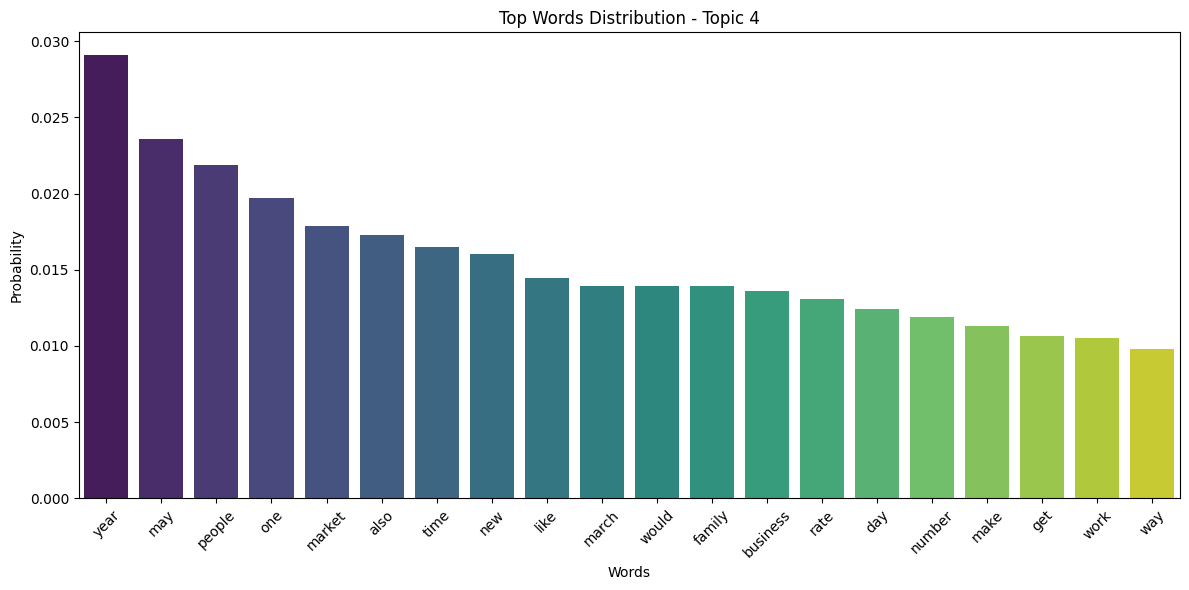

In [128]:
# Plotting the distributions
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot_4, x='Word', y='Probability', palette='viridis')

# Add title and labels
plt.title('Top Words Distribution - Topic 4')
plt.xlabel('Words')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [129]:
#Probability of each document per topic
cols = ["Topic_" + str(each) for each in range(lda.n_components)]
docs = ["Document_" + str(each) for each in range(X.shape[0])]

df_topics = pd.DataFrame(np.round(doc_topics,2),
                         columns=cols,
                         index=docs)

df_topics

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
Document_0,0.00,0.00,0.00,0.09,0.91
Document_1,0.00,0.00,0.00,0.00,0.99
Document_2,0.33,0.01,0.29,0.02,0.35
Document_3,0.19,0.04,0.15,0.08,0.54
Document_4,0.40,0.09,0.36,0.01,0.14
...,...,...,...,...,...
Document_324,0.00,0.00,0.00,0.02,0.97
Document_325,0.03,0.00,0.36,0.15,0.45
Document_326,0.00,0.02,0.49,0.00,0.48
Document_327,0.21,0.01,0.78,0.01,0.01


In [130]:
#Assigning each document the topic with the highest probability
imp_topic = np.argmax(df_topics.values, axis=1)
df_topics["top_topic"] = imp_topic
print(df_topics.head(10))

            Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  top_topic
Document_0     0.00     0.00     0.00     0.09     0.91          4
Document_1     0.00     0.00     0.00     0.00     0.99          4
Document_2     0.33     0.01     0.29     0.02     0.35          4
Document_3     0.19     0.04     0.15     0.08     0.54          4
Document_4     0.40     0.09     0.36     0.01     0.14          0
Document_5     0.08     0.05     0.14     0.40     0.34          3
Document_6     0.00     0.00     0.98     0.00     0.00          2
Document_7     0.47     0.01     0.51     0.01     0.01          2
Document_8     0.03     0.00     0.00     0.00     0.97          4
Document_9     0.19     0.00     0.73     0.04     0.03          2


In [131]:
#Adding in topic names
conditions = [df_topics["top_topic"] == 0, df_topics["top_topic"] == 1, df_topics["top_topic"] == 2, 
              df_topics["top_topic"] == 3, df_topics["top_topic"] == 4]

choices = ["Comprehensive County Data: Population, Income, and Government Resources", "National Health and Demographic Survey: Insights Across Communities", "State and Community Health Services: Access and Resources", "Housing Market Analysis: Prices, Values, and Statistics", "Annual Market Trends: Business, Family, and Economic Insights"]

df_topics["Topic_Name"] = np.select(conditions, choices, default="Other")

# Expand the columns to show the full output
pd.set_option('display.max_columns', None)

# Show top 10 rows in the DataFrame
print(df_topics.head(10))

            Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  top_topic  \
Document_0     0.00     0.00     0.00     0.09     0.91          4   
Document_1     0.00     0.00     0.00     0.00     0.99          4   
Document_2     0.33     0.01     0.29     0.02     0.35          4   
Document_3     0.19     0.04     0.15     0.08     0.54          4   
Document_4     0.40     0.09     0.36     0.01     0.14          0   
Document_5     0.08     0.05     0.14     0.40     0.34          3   
Document_6     0.00     0.00     0.98     0.00     0.00          2   
Document_7     0.47     0.01     0.51     0.01     0.01          2   
Document_8     0.03     0.00     0.00     0.00     0.97          4   
Document_9     0.19     0.00     0.73     0.04     0.03          2   

                                                   Topic_Name  
Document_0  Annual Market Trends: Business, Family, and Ec...  
Document_1  Annual Market Trends: Business, Family, and Ec...  
Document_2  Annual Market Trends: Bus

In [132]:
#Adding topics into original DF
conditions = [df_topics["top_topic"] == 0, df_topics["top_topic"] == 1, df_topics["top_topic"] == 2, 
              df_topics["top_topic"] == 3, df_topics["top_topic"] == 4]

choices = ["Comprehensive County Data: Population, Income, and Government Resources", 
           "National Health and Demographic Survey: Insights Across Communities", 
           "State and Community Health Services: Access and Resources", 
           "Housing Market Analysis: Prices, Values, and Statistics", 
           "Annual Market Trends: Business, Family, and Economic Insights"]
final_data.loc[:,"Topic_Name"] = np.select(conditions, choices, default="Other")

final_data

,url,Found Links,Source,content,Topic_Name
0,http://bonddad.blogspot.com/2021/12/manufactur...,[http://www.census.gov/econ/www/],cited,the bonddad blog manufacturing still red hot c...,"Annual Market Trends: Business, Family, and Ec..."
1,http://bonddad.blogspot.com/2023/09/initial-jo...,[http://www.census.gov/econ/www/],cited,the bonddad blog initial jobless claim remain ...,"Annual Market Trends: Business, Family, and Ec..."
2,http://bostongis.org/?content_name=umn_datasou...,[http://www.census.gov/geo/www/tiger/index.htm...,cited,ogr odbcboston geographic information systemsh...,"Annual Market Trends: Business, Family, and Ec..."
3,http://colonialsense.com/society-lifestyle/cen...,[mailto:?subject=colonial sense: society-lifes...,cited,colonial sense societylifestyle census governa...,"Annual Market Trends: Business, Family, and Ec..."
4,http://fileformats.archiveteam.org/index.php?t...,[https://www.census.gov/programs-surveys/cps.h...,cited,cps project just solve the file format problem...,"Comprehensive County Data: Population, Income,..."
...,...,...,...,...,...
324,https://www.withdra.com/p/mind-the-gap-explori...,[https://www.census.gov/library/publications/2...,cited,vibecession exploring the growing divide betwe...,"Annual Market Trends: Business, Family, and Ec..."
325,https://www.wxpr.org/2022-07-28/these-hurrican...,[https://data.census.gov/],repackaged,these hurricane flood map reveal the climate f...,"Annual Market Trends: Business, Family, and Ec..."
326,https://www.wyomingpublicmedia.org/news/2021-0...,[https://www.census.gov/data/experimental-data...,repackaged,single mother bore brunt of coronavirus anxiet...,State and Community Health Services: Access an...
327,https://yelmwa.gov/i_want_to/contact/send_a_no...,[https://2020census.gov/en],cited,welcome to yelm washingtonskip to contentsearc...,State and Community Health Services: Access an...


In [133]:
#Simple count of topics
df_topics['Topic_Name'].value_counts()

Topic_Name
State and Community Health Services: Access and Resources                  124
Annual Market Trends: Business, Family, and Economic Insights              115
Comprehensive County Data: Population, Income, and Government Resources     69
Housing Market Analysis: Prices, Values, and Statistics                     11
National Health and Demographic Survey: Insights Across Communities         10
Name: count, dtype: int64

## Mapping

In [134]:
from geopy.geocoders import Nominatim
from tqdm import tqdm
import re
import socket
import pandas as pd
import time
from ip2geotools.databases.noncommercial import DbIpCity
import idna

# Function to get the details of the IP address including city, country, coordinates, etc.
def get_details(ip):
    res = DbIpCity.get(ip, api_key="free")
    return {
        "IP Address": res.ip_address,
        "City": res.city,
        "Region": res.region,
        "Country": res.country,
        "latitude": res.latitude, # we will get errors for latitude and longitude; this is resolved in the next step
        "longitude": res.longitude
    }

# Function to process a list of URLs and save the results into a DataFrame
def process_urls(urls):
    data = []
    for url in urls:
        try:
            domain = url.split('//')[-1].split('/')[0]
            ip_add = socket.gethostbyname(domain)
            details = get_details(ip_add)
            details["URL"] = url
            data.append(details)
            time.sleep(1)  # Add delay to prevent rate limiting
        except socket.gaierror:
            print(f"Could not resolve {url}: DNS resolution failed")
        except idna.core.IDNAError as e:
            print(f"Could not process {url}: {e}")
        except Exception as e:
            print(f"Could not process {url}: {e}")

    df = pd.DataFrame(data)
    return df

# List of URLs to process
urls = final_data['url']
urls = list(set(urls)) # remove duplicate urls

# Process each URL and save the results into a DataFrame
map_df_r = process_urls(urls)
print(map_df_r)

Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Tampa%2C+Florida+US&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Tampa%2C+US&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Toronto%2C+Ontario+CA&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Toronto%2C+CA&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=B

Could not resolve https://hcup-us.ahrq.gov:443/reports/statbriefs/sb138.jsp: DNS resolution failed


Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Kansas+City%2C+Missouri+US&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Kansas+City%2C+US&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Toronto%2C+Ontario+CA&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.org/search?q=Toronto%2C+CA&format=jsonv2&addressdetails=1&limit=1
Status code 403 from https://nominatim.openstreetmap.org/search: ERROR - 403 Client Error: Forbidden for url: https://nominatim.openstreetmap.o

          IP Address                        City      Region Country  \
0     207.38.102.103                 Los Angeles  California      US   
1      18.165.116.35                     Atlanta     Georgia      US   
2       104.18.10.22                     Toronto     Ontario      CA   
3       54.204.66.44                     Ashburn    Virginia      US   
4     207.38.102.103                 Los Angeles  California      US   
..               ...                         ...         ...     ...   
323    18.165.116.96                     Atlanta     Georgia      US   
324  162.254.252.238                   Cleveland        Ohio      US   
325  192.229.163.160   Los Angeles (Playa Vista)  California      US   
326   192.229.163.47   Los Angeles (Playa Vista)  California      US   
327    199.34.228.77  Oakland (Downtown Oakland)  California      US   

      latitude   longitude                                                URL  
0    34.053691 -118.242766  http://www.shashijaggia.com

In [135]:
map_df_r['City'] = map_df_r['City'].apply(lambda x: re.sub(r'\(.*?\)', '', x).strip()) # removing data in parenthesis for city so we can get lat and long

# Initialize the geolocator
geolocator = Nominatim(user_agent="capstone_data_pull2")

# Function to get latitude and longitude
def get_lat_long(city, region, country):
    location = geolocator.geocode(f"{city}, {region}, {country}", timeout=10)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

for index, row in tqdm(map_df_r.iterrows(), total=map_df_r.shape[0]):
    latitude, longitude = get_lat_long(row['City'], row['Region'], row['Country'])
    map_df_r.at[index, 'latitude'] = latitude
    map_df_r.at[index, 'longitude'] = longitude

100%|██████████| 328/328 [03:25<00:00,  1.59it/s]


In [136]:
# Renaming the column
map_df_r.rename(columns={'URL': 'url'}, inplace=True)
map_df_r

,IP Address,City,Region,Country,latitude,longitude,url
0,207.38.102.103,Los Angeles,California,US,34.053691,-118.242766,http://www.shashijaggia.com/438-s-buena-vista-...
1,18.165.116.35,Atlanta,Georgia,US,33.748992,-84.390264,https://statisticalatlas.com/zip/62434/overview
2,104.18.10.22,Toronto,Ontario,CA,43.653482,-79.383935,https://www.citytowninfo.com/places/north-caro...
3,54.204.66.44,Ashburn,Virginia,US,39.043719,-77.487490,https://meps.ahrq.gov/data_stats/download_data...
4,207.38.102.103,Los Angeles,California,US,34.053691,-118.242766,http://www.janetpepedavis.com/2528-dekoven-bel...
...,...,...,...,...,...,...,...
323,18.165.116.96,Atlanta,Georgia,US,33.748992,-84.390264,https://statisticalatlas.com/place/alabama/pin...
324,162.254.252.238,Cleveland,Ohio,US,41.499657,-81.693677,https://hopewelltwp.com/documents/resolution-r...
325,192.229.163.160,Los Angeles,California,US,34.053691,-118.242766,https://kffm.com/ixp/113/p/wine-pairing-dinner...
326,192.229.163.47,Los Angeles,California,US,34.053691,-118.242766,https://espnsiouxfalls.com/two-south-dakota-co...


In [137]:
# Merge the DataFrames on the 'URL' column
map_df_r_t = pd.merge(map_df_r, final_data, on='url', how='inner')  # Use 'inner' for intersection, 'outer' for union, etc.

print(map_df_r_t)

          IP Address         City      Region Country   latitude   longitude  \
0     207.38.102.103  Los Angeles  California      US  34.053691 -118.242766   
1      18.165.116.35      Atlanta     Georgia      US  33.748992  -84.390264   
2       104.18.10.22      Toronto     Ontario      CA  43.653482  -79.383935   
3       54.204.66.44      Ashburn    Virginia      US  39.043719  -77.487490   
4     207.38.102.103  Los Angeles  California      US  34.053691 -118.242766   
..               ...          ...         ...     ...        ...         ...   
323    18.165.116.96      Atlanta     Georgia      US  33.748992  -84.390264   
324  162.254.252.238    Cleveland        Ohio      US  41.499657  -81.693677   
325  192.229.163.160  Los Angeles  California      US  34.053691 -118.242766   
326   192.229.163.47  Los Angeles  California      US  34.053691 -118.242766   
327    199.34.228.77      Oakland  California      US  37.804456 -122.271356   

                                       

In [138]:
#Splitting data into two dataframes
repackaged_data = map_df_r_t[map_df_r_t['Source'] == 'repackaged']
cited_data = map_df_r_t[map_df_r_t['Source'] == 'cited']

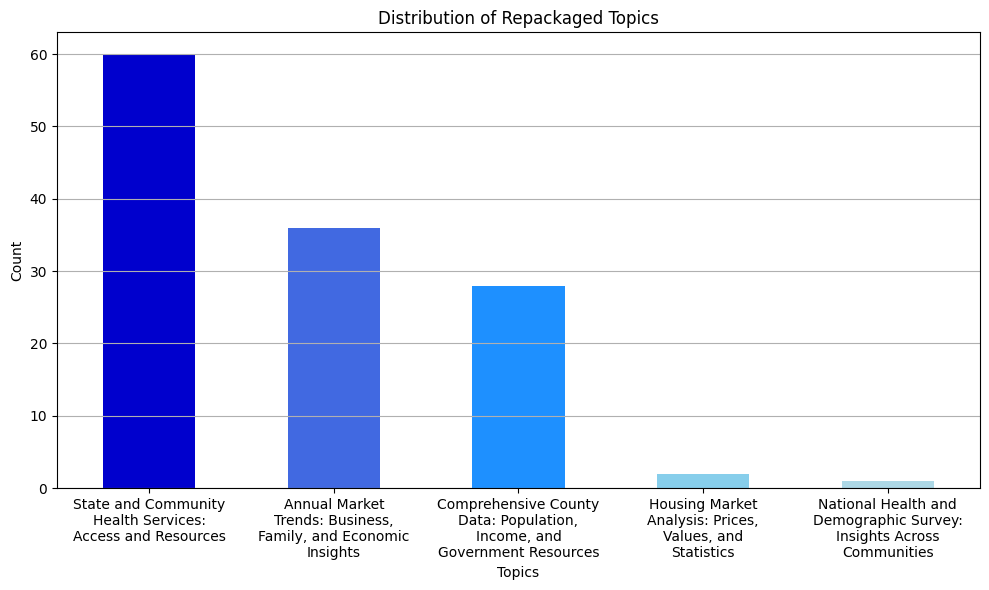

In [139]:
#Plotting distribution of repackaged topics

import matplotlib.pyplot as plt
import textwrap

# Get the value counts
topic_counts = repackaged_data['Topic_Name'].value_counts()

# Define a list of blue shades
blue_shades = ['#0000CD', '#4169E1', '#1E90FF', '#87CEEB', '#ADD8E6']

# Wrap the x-axis labels
wrapped_labels = [textwrap.fill(label, width=20) for label in topic_counts.index]

# Create a bar chart
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color=blue_shades[:len(topic_counts)])
plt.title('Distribution of Repackaged Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

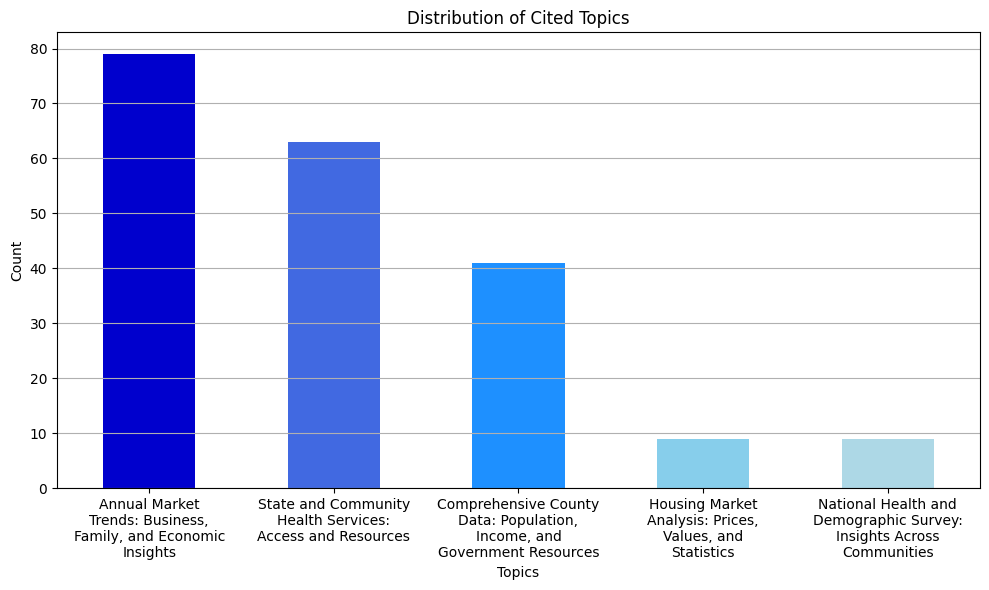

In [140]:
#Plotting distribution of cited topics

import matplotlib.pyplot as plt
import textwrap

# Get the value counts
topic_counts = cited_data['Topic_Name'].value_counts()

# Define a list of blue shades
blue_shades = ['#0000CD', '#4169E1', '#1E90FF', '#87CEEB', '#ADD8E6']

# Wrap the x-axis labels
wrapped_labels = [textwrap.fill(label, width=20) for label in topic_counts.index]

# Create a bar chart
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color=blue_shades[:len(topic_counts)])
plt.title('Distribution of Cited Topics')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Mapping Data

In [141]:
#Mapping repackaged data
import plotly.graph_objects as go

# Define a color map for the topics
color_map = {
    'Comprehensive County Data: Population, Income, and Government Resources': 'blue',
    'National Health and Demographic Survey: Insights Across Communities': 'green',
    'State and Community Health Services: Access and Resources': 'red',
    'Housing Market Analysis: Prices, Values, and Statistics': 'purple',
    'Annual Market Trends: Business, Family, and Economic Insights': 'orange',
    'Other': 'gray'
}

# Map the Topic_Name to colors
repackaged_data['color'] = repackaged_data['Topic_Name'].map(color_map)

# Create the scatter geo plot
fig = go.Figure(data=go.Scattergeo(
    lon=repackaged_data['longitude'],
    lat=repackaged_data['latitude'],
    mode='markers',
    text=repackaged_data['url'],
    hoverinfo='text',
    marker=dict(color=repackaged_data['color'], size=10, line=dict(width=1, color='black')),
    showlegend=False
))

# Update the layout to include a legend
fig.update_layout(
    title='Instances of Repackaged Census Data',
    geo_scope='north america',
    legend_title_text='Topics',
    legend=dict(
        itemsizing='constant'
    )
)

# Add legend items manually
for topic, color in color_map.items():
    fig.add_trace(go.Scattergeo(
        lon=[None], lat=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        name=topic
    ))

# Show the plot
fig.show()

C:\Users\Ksell\AppData\Local\Temp\ipykernel_45544\3646831006.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
import plotly.io as pio
# Save the interactive graph to an HTML file to imbed in the powerpoint presentation
pio.write_html(fig, file='Repackaged_Census_Data_Map.html', auto_open=True)

In [143]:
#Mapping cited data
import plotly.graph_objects as go

# Define a color map for the topics
color_map = {
    'Comprehensive County Data: Population, Income, and Government Resources': 'blue',
    'National Health and Demographic Survey: Insights Across Communities': 'green',
    'State and Community Health Services: Access and Resources': 'red',
    'Housing Market Analysis: Prices, Values, and Statistics': 'purple',
    'Annual Market Trends: Business, Family, and Economic Insights': 'orange',
    'Other': 'gray'
}

# Map the Topic_Name to colors
cited_data['color'] = cited_data['Topic_Name'].map(color_map)

# Create the scatter geo plot
fig = go.Figure(data=go.Scattergeo(
    lon=cited_data['longitude'],
    lat=cited_data['latitude'],
    mode='markers',
    text=cited_data['url'],
    hoverinfo='text',
    marker=dict(color=cited_data['color'], size=10, line=dict(width=1, color='black')),
    showlegend=False
))

# Update the layout to include a legend
fig.update_layout(
    title='Instances of Cited Census Data',
    geo_scope='north america',
    legend_title_text='Topics',
    legend=dict(
        itemsizing='constant'
    )
)

# Add legend items manually
for topic, color in color_map.items():
    fig.add_trace(go.Scattergeo(
        lon=[None], lat=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        name=topic
    ))

# Show the plot
fig.show()

C:\Users\Ksell\AppData\Local\Temp\ipykernel_45544\3921446242.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [144]:
import plotly.io as pio
# Save the interactive graph to an HTML file to imbed in the powerpoint presentation
pio.write_html(fig, file='Cited_Census_Data_Map.html', auto_open=True)

## Link Analysis

In [5]:
#Identify patterns for repackaged links
data_tables_patterns = ['table', 'dataset', 'data', 'productview']
repackaged_data_tables_urls = [url for url in urls if any(pattern in url for pattern in data_tables_patterns)]
cited_data_tables_urls = [url for url in urls if not any(pattern in url for pattern in data_tables_patterns)]

In [6]:
#Parse URLS to extract domain names
from urllib.parse import urlparse

r_domains = [urlparse(url).netloc for url in repackaged_data_tables_urls]
c_domains = [urlparse(url).netloc for url in cited_data_tables_urls]

Repackaged

In [7]:
#Counting domain names
from collections import Counter

r_domain_counts = Counter(r_domains)
r_most_common_domains = r_domain_counts.most_common(15)

In [8]:
r_data_table_counts = Counter(repackaged_data_tables_urls)
r_most_common_data_tables = r_data_table_counts.most_common(15)

In [9]:
#Printing results
print("Most frequent domains:")
for domain, count in r_most_common_data_tables:
    print(f"{domain}: {count}")



Most frequent domains:
https://www.census.gov/quickfacts/fact/table/US/PST045222: 12
https://web.archive.org/web/20111028064539/http://2010.census.gov/2010census/data/apportionment-pop-text.php: 11
https://data.census.gov/cedsci/: 9
https://data.census.gov/: 9
https://www.census.gov/quickfacts/fact/table/keywestcityflorida,putnamcountyflorida/PST045221: 8
https://www.census.gov/quickfacts/fact/table/cuyahogacountyohio/PST045219: 4
https://www.census.gov/data/software/x13as.html: 4
http://www.census.gov/foreign-trade/data/index.html: 4
https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html: 3
https://data.census.gov/cedsci/table?t=Income%20and%20Poverty&g=0100000US,%241600000&tid=ACSST5Y2020.S1902: 3
http://www.census.gov/data/data-tools.html: 3
https://www.census.gov/quickfacts/fact/table/broomecountynewyork/PST045219: 2
https://meta.geo.census.gov/data/existing/decennial/GEO/GPMB/TIGERline/Tiger2019/roads/tl_2019_roads.ea.iso.xml: 2
https

In [10]:
print("\nMost frequent data table URLs:")
for url, count in r_most_common_data_tables:
    print(f"{url}: {count}")


Most frequent data table URLs:
https://www.census.gov/quickfacts/fact/table/US/PST045222: 12
https://web.archive.org/web/20111028064539/http://2010.census.gov/2010census/data/apportionment-pop-text.php: 11
https://data.census.gov/cedsci/: 9
https://data.census.gov/: 9
https://www.census.gov/quickfacts/fact/table/keywestcityflorida,putnamcountyflorida/PST045221: 8
https://www.census.gov/quickfacts/fact/table/cuyahogacountyohio/PST045219: 4
https://www.census.gov/data/software/x13as.html: 4
http://www.census.gov/foreign-trade/data/index.html: 4
https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html: 3
https://data.census.gov/cedsci/table?t=Income%20and%20Poverty&g=0100000US,%241600000&tid=ACSST5Y2020.S1902: 3
http://www.census.gov/data/data-tools.html: 3
https://www.census.gov/quickfacts/fact/table/broomecountynewyork/PST045219: 2
https://meta.geo.census.gov/data/existing/decennial/GEO/GPMB/TIGERline/Tiger2019/roads/tl_2019_roads.ea.iso.xml

In [11]:
# Extracting additional insights

# 1. Identify the most common URL paths
r_paths = [urlparse(url).path for url in repackaged_data_tables_urls]
r_path_counts = Counter(r_paths)
r_most_common_paths = r_path_counts.most_common(10)

print("\nMost common URL paths:")
for path, count in r_most_common_paths:
    print(f"{path}: {count}")



Most common URL paths:
/cedsci/table: 14
/quickfacts/fact/table/US/PST045222: 12
/web/20111028064539/http://2010.census.gov/2010census/data/apportionment-pop-text.php: 11
/cedsci/: 9
/: 9
/quickfacts/fact/table/keywestcityflorida,putnamcountyflorida/PST045221: 8
/quickfacts/fact/table/cuyahogacountyohio/PST045219: 4
/data/software/x13as.html: 4
/foreign-trade/data/index.html: 4
/all: 4


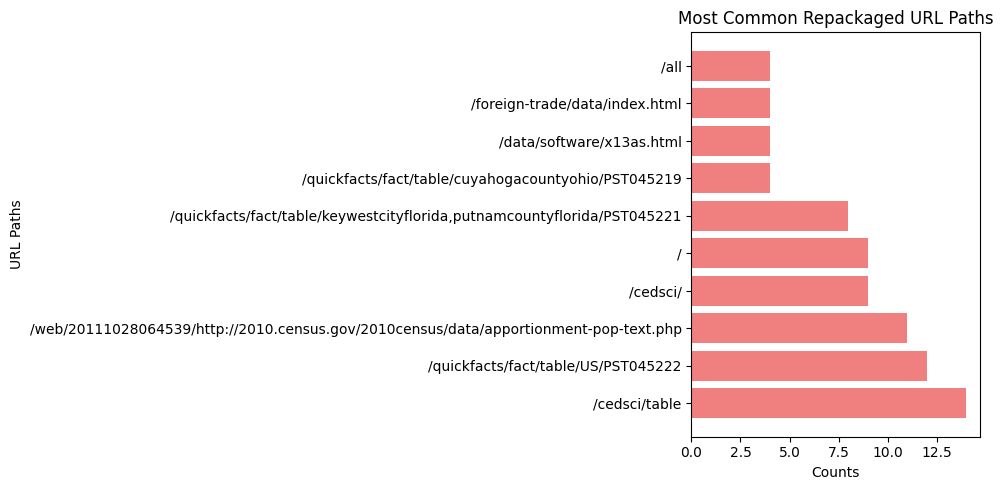

In [12]:
# Separate paths and counts for plotting
if r_most_common_paths:
    paths, counts = zip(*r_most_common_paths)
else:
    paths, counts = [], []

# Plot the graph
plt.figure(figsize=(10, 5))
plt.barh(paths, counts, color='lightcoral')
plt.xlabel('Counts')
plt.ylabel('URL Paths')
plt.title('Most Common Repackaged URL Paths')
plt.tight_layout()
plt.show()

In [13]:
# 2. Identify the most common query parameters
r_queries = [urlparse(url).query for url in repackaged_data_tables_urls]
r_query_counts = Counter(r_queries)
r_most_common_queries = r_query_counts.most_common(10)

print("\nMost common query parameters:")
for query, count in r_most_common_queries:
    print(f"{query}: {count}")


Most common query parameters:
: 156
t=Income%20and%20Poverty&g=0100000US,%241600000&tid=ACSST5Y2020.S1902: 3
pid=DEC_10_SF1_GCTPH1.ST13&prodType=table: 2
_program=DEC&_tabId=DEC1&_submenuId=datasets_1&_lang=en&_ts=224246209722: 2
q=mortgage: 2
q=Age%20By%20State&g=0100000US.04000.001&tid=ACSST1Y2019.S0101&hidePreview=true&moe=false&tp=true: 2
d=ACS%205-Year%20Estimates%20Detailed%20Tables: 2
t=Populations%20and%20People&g=0100000US,%241600000&y=2020: 2
g=0100000US%241600000&y=2010&d=DEC%20Redistricting%20Data%20%28PL%2094-171%29: 2
q=S2901%3A%20CITIZEN,%20VOTING-AGE%20POPULATION%20BY%20SELECTED%20CHARACTERISTICS&g=0400000US37&tid=ACSST1Y2019.S2901: 1


In [14]:
# 3. Identify the most common URL schemes (http, https, etc.)
r_schemes = [urlparse(url).scheme for url in repackaged_data_tables_urls]
r_scheme_counts = Counter(r_schemes)
r_most_common_schemes = r_scheme_counts.most_common()

print("\nMost common URL schemes:")
for scheme, count in r_most_common_schemes:
    print(f"{scheme}: {count}")


Most common URL schemes:
https: 168
http: 18
mailto: 2


In [25]:
import plotly.express as px
import pandas as pd

# Assuming 'tables' and 'counts' are already defined as lists of table names and counts
# Example: tables = ['Table 1', 'Table 2', ...]
#          counts = [50, 30, ...]
tables, counts = zip(*r_most_common_paths)
# Create a DataFrame from the tables and counts
data = {'Census Table': tables, 'Number of References': counts}
df = pd.DataFrame(data)

# Create an interactive horizontal bar chart
fig = px.bar(df, 
             x='Number of References', 
             y='Census Table', 
             orientation='h',  # Horizontal bars
             title="Top 15 Most Referenced U.S. Census Tables in Repackaged Instances",
             labels={'Number of References': 'Number of References', 'Census Table': 'Census Table'},
             color='Number of References',  # Color bars based on count
             text='Number of References')  # Show count on hover

# Customize the hover data (you can modify this to include more details)
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Invert the y-axis to show the highest count at the top
fig.update_yaxes(categoryorder='total descending')

# Show the interactive plot
fig.show()

# Cited Links

In [16]:
#Counting domain names
from collections import Counter

c_domain_counts = Counter(c_domains)
c_most_common_domains = c_domain_counts.most_common(15)

In [17]:
c_data_table_counts = Counter(cited_data_tables_urls)
c_most_common_data_tables = c_data_table_counts.most_common(15)

In [18]:
#Printing results
print("Most frequent Cited domains:")
for domain, count in c_most_common_data_tables:
    print(f"{domain}: {count}")

Most frequent Cited domains:
http://www.census.gov/: 42
/organization/census-gov: 21
https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018.pdf: 15
https://www.census.gov/programs-surveys/saipe/about.html: 14
/organization/about/census-gov: 14
https://www.census.gov/: 13
http://www.census.gov/retail/index.html: 12
http://www.census.gov/hhes/www/disability/ACS_disability.pdf: 12
http://www.census.gov: 11
https://www.census.gov/programs-surveys/acs/: 11
https://qwiexplorer.ces.census.gov/: 10
https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html: 8
http://www.census.gov/acs: 8
https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer: 6
mailto:geo.geography@census.gov: 6


In [19]:
print("\nMost frequent Cited data table URLs:")
for url, count in c_most_common_data_tables:
    print(f"{url}: {count}")


Most frequent Cited data table URLs:
http://www.census.gov/: 42
/organization/census-gov: 21
https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018.pdf: 15
https://www.census.gov/programs-surveys/saipe/about.html: 14
/organization/about/census-gov: 14
https://www.census.gov/: 13
http://www.census.gov/retail/index.html: 12
http://www.census.gov/hhes/www/disability/ACS_disability.pdf: 12
http://www.census.gov: 11
https://www.census.gov/programs-surveys/acs/: 11
https://qwiexplorer.ces.census.gov/: 10
https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html: 8
http://www.census.gov/acs: 8
https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer: 6
mailto:geo.geography@census.gov: 6


In [20]:
# Extracting additional insights

# 1. Identify the most common URL paths
c_paths = [urlparse(url).path for url in cited_data_tables_urls]
c_path_counts = Counter(c_paths)
c_most_common_paths = c_path_counts.most_common(10)

print("\nMost common Cited URL paths:")
for path, count in c_most_common_paths:
    print(f"{path}: {count}")


Most common Cited URL paths:
/: 75
: 27
/organization/census-gov: 21
/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018.pdf: 15
/programs-surveys/saipe/about.html: 14
/organization/about/census-gov: 14
/retail/index.html: 12
/programs-surveys/acs/: 12
/hhes/www/disability/ACS_disability.pdf: 12
/naics/: 10


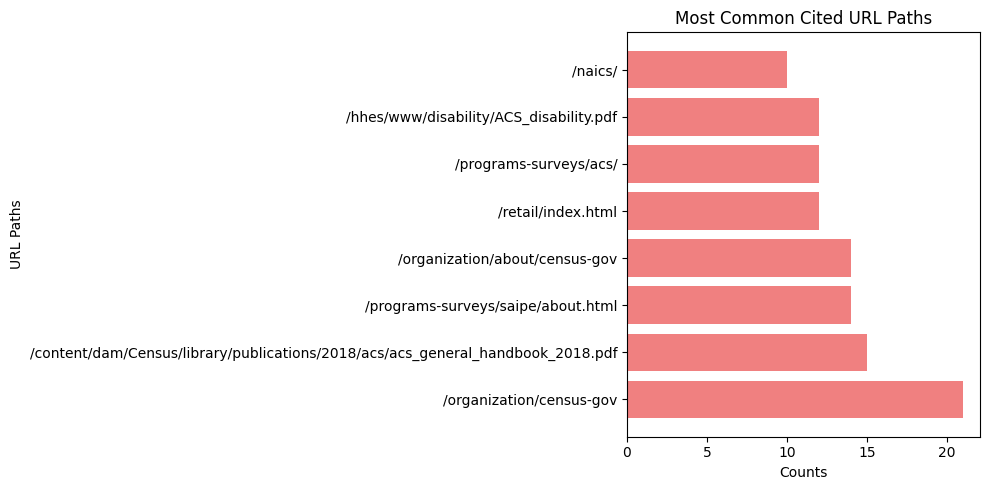

In [21]:
# Filter paths with counts of 21 and under
c_filtered_paths = [(path, count) for path, count in c_most_common_paths if count <= 21]

# Separate paths and counts for plotting
if c_most_common_paths:
    paths, counts = zip(*c_filtered_paths)
else:
    paths, counts = [], []

# Plot the graph
plt.figure(figsize=(10, 5))
plt.barh(paths, counts, color='lightcoral')
plt.xlabel('Counts')
plt.ylabel('URL Paths')
plt.title('Most Common Cited URL Paths')
plt.tight_layout()
plt.show()

In [22]:
# 2. Identify the most common query parameters
c_queries = [urlparse(url).query for url in cited_data_tables_urls]
c_query_counts = Counter(c_queries)
c_most_common_queries = c_query_counts.most_common(10)

print("\nMost common Cited query parameters:")
for query, count in c_most_common_queries:
    print(f"{query}: {count}")


Most common Cited query parameters:
: 552
subject=Colonial Sense: Society-Lifestyle: Census: Governance&body=http://colonialsense.com/society-lifestyle/census/governance.php?cs=12970: 2
text=Colonial Sense: Society-Lifestyle: Census: Governance:%20&url=http://colonialsense.com/society-lifestyle/census/governance.php?cs=12970: 2
u=http://colonialsense.com/society-lifestyle/census/governance.php?cs=12970: 2
searchtype=web&cssp=serp&q=lake%20orion%20village,%20michigan: 2
url=http%3a%2f%2ffactfinder2.census.gov%2fbkmk%2fqs%2f1.0%2fen%2fgeo_search%3a95030&pp=80589: 1
url=http%3a%2f%2ffactfinder2.census.gov%2fbkmk%2fqs%2f1.0%2fen%2fgeo_search%3a95008&pp=42647: 1
url=http%3a%2f%2ffactfinder2.census.gov%2fbkmk%2fqs%2f1.0%2fen%2fgeo_search%3a95628&pp=566920: 1
url=http%3a%2f%2ffactfinder2.census.gov%2fbkmk%2fqs%2f1.0%2fen%2fgeo_search%3a95014&pp=84517: 1
input=51224&year=2022&details=51224: 1


In [23]:
# 3. Identify the most common URL schemes (http, https, etc.)
c_schemes = [urlparse(url).scheme for url in cited_data_tables_urls]
c_scheme_counts = Counter(c_schemes)
c_most_common_schemes = c_scheme_counts.most_common()

print("\nMost common Cited URL schemes:")
for scheme, count in c_most_common_schemes:
    print(f"{scheme}: {count}")


Most common Cited URL schemes:
https: 347
http: 173
: 54
mailto: 10


In [24]:
import plotly.express as px
import pandas as pd

# Assuming 'tables' and 'counts' are already defined as lists of table names and counts
# Example: tables = ['Table 1', 'Table 2', ...]
#          counts = [50, 30, ...]
tables, counts = zip(*c_most_common_paths)
# Create a DataFrame from the tables and counts
data = {'Census Table': tables, 'Number of References': counts}
df = pd.DataFrame(data)

# Create an interactive horizontal bar chart
fig = px.bar(df, 
             x='Number of References', 
             y='Census Table', 
             orientation='h',  # Horizontal bars
             title="Top 15 Most Referenced U.S. Census Tables in Cited Instances",
             labels={'Number of References': 'Number of References', 'Census Table': 'Census Table'},
             color='Number of References',  # Color bars based on count
             text='Number of References')  # Show count on hover

# Customize the hover data (you can modify this to include more details)
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Invert the y-axis to show the highest count at the top
fig.update_yaxes(categoryorder='total descending')

# Show the interactive plot
fig.show()